# Setup

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
def make_synthetic_data(init_win_rate,
                        final_win_rate,
                        rounds,
                        noise=0,
                        seed=0,
                        rating_type="linear"):
    np.random.seed(seed)
    if init_win_rate == 0 and final_win_rate == 0.5:
        print("warning: function has been updated")
    probs = np.linspace(init_win_rate,
                        final_win_rate,
                        rounds)
    results = []
    for p in probs:
        result = np.random.binomial(n=1, p=p)
        if result == 0:
            result += 0.5 * np.random.binomial(n=1, p=0.5)
        results.append(result)
    results = np.array(results)
    if rating_type == "linear":
        rating = probs
    elif rating_type == "convex":
        rating = 1/3 + (1/(3 * rounds ** 2)) * np.arange(rounds) ** 2
    elif rating_type == "concave":
        rating = 2/3 - (1/(3 * rounds ** 2)) * (np.arange(rounds) - rounds) ** 2
    elif rating_type == "sigmoid":
        rating = 1/3 + 1/3 * ( 1 / (1 + np.exp(- 0.1 * np.arange(rounds) + rounds / 20)) )
    elif rating_type == "likelihood":
        rating = np.array([np.mean(results[max(0, i-4): i+1]==1) for i in range(len(results))])
    elif rating_type == "linear_likelihood":
        rating = (probs + np.array([np.mean(results[max(0, i-4): i+1]==1) for i in range(len(results))])) / 2
    elif rating_type == "cumul_average":
        rating = np.cumsum(results)/(np.arange(len(results)) + 1)
    elif rating_type == "raw":
        rating = results
    rating += np.random.normal(0, noise, rounds)
    return np.stack((probs, results, 1-results, rating)).T

def get_syn_params(rating_type, noise=0):
    if rating_type in ["upper_constant"]:
        return {"init_win_rate": 0.5, "final_win_rate": 0.5, "rounds": 100, "noise":noise, "rating_type":"linear"}
    if rating_type in ["lower_constant"]:
        return {"init_win_rate": 0, "final_win_rate": 0, "rounds": 100, "noise":noise, "rating_type":"linear"}
    else:
        return {"init_win_rate": 0, "final_win_rate": 0.5, "rounds": 100, "noise":noise, "rating_type":rating_type}

def syn(rating_type, seed, noise=0):
    params = get_syn_params(rating_type, noise=noise)
    return make_synthetic_data(**params, seed=seed)

Text(0, 0.5, 'estimated competence')

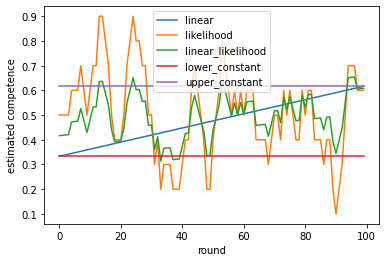

In [ ]:
for rating_type in ["linear", "likelihood", "linear_likelihood"]:
    data = make_synthetic_data(0, 0.5, 100, seed=0, noise=0.0, rating_type=rating_type)
    ratings = data[:,3]
    plt.plot(ratings, label=rating_type)
for rating_type in ["linear"]:
    data = make_synthetic_data(0, 0, 100, seed=0, noise=0, rating_type=rating_type)
    ratings = data[:,3]
    plt.plot(ratings, label="lower_constant")
for rating_type in ["linear"]:
    data = make_synthetic_data(0.5, 0.5, 100, seed=0, noise=0, rating_type=rating_type)
    ratings = data[:,3]
    plt.plot(ratings, label="upper_constant")
plt.legend()
plt.xlabel("round")
plt.ylabel("estimated competence")

In [ ]:
def plot(**kwargs):
    nargs = len(kwargs)
    fig, axs = plt.subplots(nrows=1, ncols=nargs, figsize=(nargs * 3, 2))
    if nargs == 1:
        axs = [axs]

    for i, (key, value) in enumerate(kwargs.items()):
        if type(value) is dict:
            if len(value.items()) > 2:
                all_inner_values = np.array([inner_value for inner_value in value.values()])
                mean = np.mean(all_inner_values, axis=0)
                std = np.std(all_inner_values, axis=0)
                axs[i].errorbar(np.arange(len(mean)), mean, std, linestyle='None', marker='o')
            else:
                if 'mean' in value.keys() and 'std' in value.keys():
                    mean = value['mean']
                    std = value['std']
                    axs[i].errorbar(np.arange(len(mean)), mean, std, linestyle='None', marker='o')
                else:
                    for inner_key, inner_value in value.items():
                        axs[i].plot(inner_value, label=inner_key)
                    axs[i].legend()
        else:
            axs[i].plot(value)
        axs[i].set_title(key)
        if "loss" in key or key in ["k","k_b", "k_1", "k_2", "k_c", "k_d"] or "init_R" in key:
            axs[i].set_xlabel("epoch")
            if "val" in key:
                axs[i].set_xlabel("val_epoch")
        else:
            axs[i].set_ylim((0,1))
            axs[i].set_xlabel("round")

## Synthetic Tests

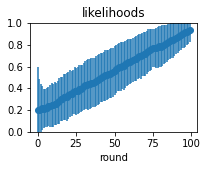

In [ ]:
init_win_rate = 0.2
final_win_rate = 0.95
rounds = 100
data = [make_synthetic_data(init_win_rate, final_win_rate, rounds, noise=0, seed=s, rating_type="likelihood") for s in range(500)]
likelihoods = np.array([d[:, 3] for d in data])
mean = likelihoods.mean(axis=0)
std = likelihoods.std(axis=0)
plot(likelihoods={"mean": mean, "std": std})

# Model

In [ ]:
class Net(nn.Module):
    def __init__(self, hidden_dim=5,
                       init_task=1):
        super(Net, self).__init__()

        self.hidden_dim = hidden_dim
        self.task_embedding = torch.nn.Parameter(torch.Tensor([init_task] * hidden_dim))
        
        self.input_mlp = nn.Sequential(
            nn.Linear(1, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim)
        )
        self.gru = nn.GRU(hidden_dim, hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()
        self.initial_hidden = torch.nn.Parameter(torch.zeros(self.hidden_dim))

    def forward(self, outcomes, hidden):
        # outcomes -> b x 100
        # outcomes = self.prep_input(outcomes)
        if hidden == None:
            hidden = self.init_hidden(outcomes.shape[1])
        input = self.input_mlp(torch.Tensor(outcomes))
        output, hidden = self.gru(input, hidden)
        return output

    def estimate_win_prob(self, hidden):
        return self.sigmoid(torch.inner(self.task_embedding, hidden))
    
    def eval_win_probs(self, outcomes):
        if isinstance(outcomes, np.ndarray):
            outcomes = torch.Tensor(outcomes).unsqueeze(1).unsqueeze(1)
        hidden = self.init_hidden(outcomes.shape[1])
        output = self(outcomes, hidden)
        preds = self.estimate_win_prob(output).detach().numpy()
        return preds

    def prep_input(self, outcomes_list):
        outcomes = torch.stack([torch.Tensor(outcome) for outcome in outcomes_list]).T.unsqueeze(-1)
        return outcomes
    
    def prep_datasets(sef, dataset_list):
        datasets = torch.stack([torch.Tensor(data) for data in dataset_list]).permute((1,0,2)).unsqueeze(-1)
        return datasets

    def init_hidden(self, batch_size):
        return self.initial_hidden.repeat(1, batch_size, 1)

# Experiments

In [ ]:
def fit_model(datasets,
              val_data_params,
              n=5, num_iters=500, lr=1e-3, val_rate=25,
              net=None, **kwargs):
    if net is None:
        net = Net(**kwargs)
    hidden = None
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    losses = []
    val_losses_mean = []
    val_losses_std = []
    reshaped_data = net.prep_datasets(datasets)
    scores_A, ys = reshaped_data[:, :, 1, :], reshaped_data[:, :, 3, :]
    for epoch in range(num_iters):
        net.train()
        preds = []
        loss = 0
        output = net(scores_A, net.init_hidden(scores_A.shape[1]))
        for i in range(len(ys)):
            y = ys[i].squeeze(-1)
            if i % n == 0:
                hidden = output[i]
                pred = net.estimate_win_prob(hidden)
                preds.append(pred)
                loss_i = -y * torch.log(pred) - (1-y) * torch.log(1 - pred)
                loss += loss_i.mean()
        optimizer.zero_grad()
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
        if epoch % val_rate == 0:
            val_out = eval_model(net, val_data_params)
            val_losses_mean.append(val_out['losses_mean'])
            val_losses_std.append(val_out['losses_std'])
    return {"net": net,
            "losses": losses,
            "val_losses_mean": val_losses_mean,
            "val_losses_std": val_losses_std
            }


In [ ]:
def eval_model(net, data_paramss, seeds=7, n=5):
    net.eval()
    losses = []
    preds = []
    for data_params in data_paramss:
        losses.append([])
        preds.append([])
        for seed in range(seeds):
            data_params["seed"] = 100 + seed
            data = make_synthetic_data(**data_params)
            reshaped_data = net.prep_datasets([data])
            scores_A, ys = reshaped_data[:, :, 1, :], reshaped_data[:, :, 3, :]
            output = net(scores_A, net.init_hidden(1))
            loss = 0
            for i in range(len(ys)):
                y = ys[i].squeeze(-1)
                if i % n  == 0:
                    hidden = output[i]
                    pred = net.estimate_win_prob(hidden)
                    loss += -y * torch.log(pred) - (1-y) * torch.log(1 - pred)
            losses[-1].append(loss.item())
            preds[-1].append(net.eval_win_probs(scores_A))
    losses = np.array(losses)
    preds = np.array(preds)[0]
    losses_mean = np.mean(losses)
    losses_std = np.std(losses)
    preds_mean = np.mean(preds, axis=0)
    preds_std = np.std(preds, axis=0)
    return {"losses": losses,
            "losses_mean": losses_mean,
            "losses_std": losses_std,
            "preds": preds,
            "preds_mean": preds_mean,
            "preds_std": preds_std}

In [ ]:
val_data_params = [get_syn_params(r) for r in ['linear_likelihood', 'upper_constant', 'lower_constant']]
train_data = [syn(r, s) for r in ['linear_likelihood', 'upper_constant', 'lower_constant'] for s in range(25)]
dataset_lin_lik = syn("linear_likelihood", 100, noise=0)
dataset_upper_const = syn("upper_constant", 100, noise=0)
dataset_lower_const = syn("lower_constant", 100, noise=0)

In [ ]:
out = fit_model( train_data, val_data_params, num_iters=1500, hidden_dim=5, lr=1e-3)

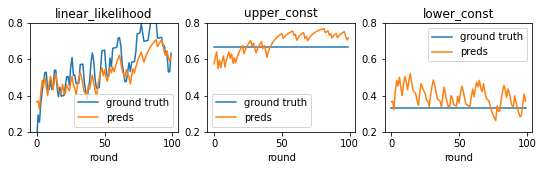

In [ ]:
preds_lin_lik = out["net"].eval_win_probs(dataset_lin_lik[:, 1])
preds_upper_const = out["net"].eval_win_probs(dataset_upper_const[:, 1])
preds_lower_const = out["net"].eval_win_probs(dataset_lower_const[:, 1])

plot(linear_likelihood={'ground truth': dataset_lin_lik[:, 3], 'preds': preds_lin_lik},
     upper_const={'ground truth': dataset_upper_const[:, 3], 'preds': preds_upper_const},
     lower_const={'ground truth': dataset_lower_const[:, 3], 'preds': preds_lower_const})

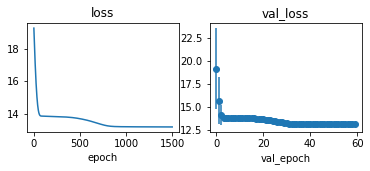

In [ ]:
plot(loss=out['losses'], val_loss={'mean': out['val_losses_mean'], 'std': out['val_losses_std']})

In [ ]:
val_data_params = [get_syn_params(r) for r in ['linear_likelihood', 'upper_constant', 'lower_constant']]
train_data = [syn(r, s) for r in ['linear_likelihood', 'upper_constant', 'lower_constant'] for s in range(10)]
dataset_lin_lik = syn("linear_likelihood", 100, noise=0)
dataset_upper_const = syn("upper_constant", 100, noise=0)
dataset_lower_const = syn("lower_constant", 100, noise=0)

In [ ]:
out = fit_model( train_data, val_data_params, num_iters=1500, hidden_dim=5, lr=1e-3)

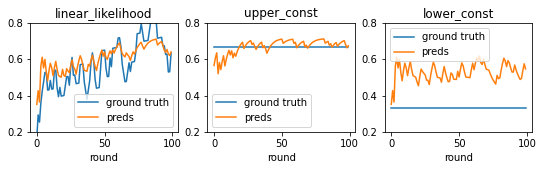

In [ ]:
preds_lin_lik = out["net"].eval_win_probs(dataset_lin_lik[:, 1])
preds_upper_const = out["net"].eval_win_probs(dataset_upper_const[:, 1])
preds_lower_const = out["net"].eval_win_probs(dataset_lower_const[:, 1])

plot(linear_likelihood={'ground truth': dataset_lin_lik[:, 3], 'preds': preds_lin_lik},
     upper_const={'ground truth': dataset_upper_const[:, 3], 'preds': preds_upper_const},
     lower_const={'ground truth': dataset_lower_const[:, 3], 'preds': preds_lower_const})

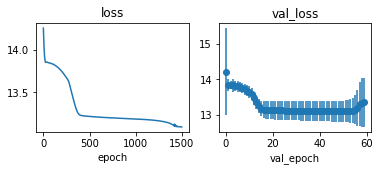

In [ ]:
plot(loss=out['losses'], val_loss={'mean': out['val_losses_mean'], 'std': out['val_losses_std']})

In [ ]:
val_data_params = [get_syn_params(r) for r in ['linear_likelihood']]
train_data = [syn(r, s) for r in ['linear_likelihood'] for s in range(3)]
dataset_lin_lik = syn("linear_likelihood", 100, noise=0)

In [ ]:
out = fit_model( train_data, val_data_params, num_iters=350, hidden_dim=5, lr=1e-3)

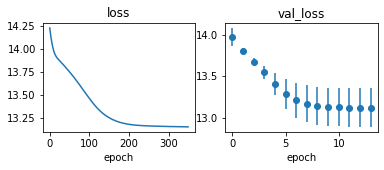

In [ ]:
plot(loss=out['losses'], val_loss={'mean': out['val_losses_mean'], 'std': out['val_losses_std']})

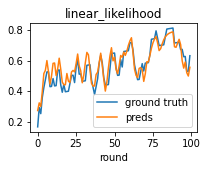

In [ ]:
preds_lin_lik = out["net"].eval_win_probs(dataset_lin_lik[:, 1])

plot(linear_likelihood={'ground truth': dataset_lin_lik[:, 3], 'preds': preds_lin_lik})

In [ ]:
val_data_params = [get_syn_params(r) for r in ['likelihood']]
train_data = [syn(r, s) for r in ['likelihood'] for s in range(3)]
dataset_lik = syn("likelihood", 100, noise=0)

In [ ]:
out = fit_model( train_data, val_data_params, num_iters=350, hidden_dim=5, lr=1e-3)

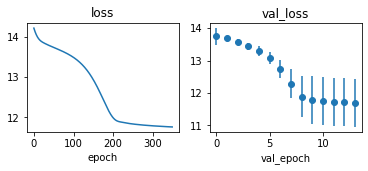

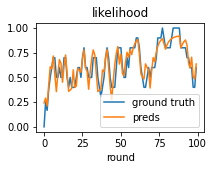

In [ ]:
preds_lik = out["net"].eval_win_probs(dataset_lin_lik[:, 1])

plot(loss=out['losses'], val_loss={'mean': out['val_losses_mean'], 'std': out['val_losses_std']})
plot(likelihood={'ground truth': dataset_lik[:, 3], 'preds': preds_lik})

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=199ccc49-bf50-455b-987a-f3756c1aa6a2' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>